In [76]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from scipy.special import iv
from statsmodels.tsa.arima.model import ARIMA

In [2]:
h_lag = 1
rho =1
iv(h_lag,2*rho)/iv(0,2*rho)

0.697774657964008

In [30]:
def mets_filter(ts,rho,alpha):
    ts_mean = np.mean(ts)
    ts = np.append(ts,ts_mean)
    sample_size = len(ts)
    
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1

    L_approx[sample_size -1 ] = np.zeros(sample_size)
    filter_matrix = expm(rho*L_approx)
    
    output = np.dot(filter_matrix,ts) + alpha

    return output[:-1]

def ols_mets(ts,grid_size):
    min_alpha = 0.0
    min_rho = 0.0
    min_obj = np.square(mets_filter(ts, 0.0, 0.0)).mean()
    ts_mean  = np.mean(ts)
    
    for alpha in np.linspace(-ts_mean, ts_mean, grid_size):
        for rho in np.linspace(-2,2,grid_size):
            obj = np.square(mets_filter(ts, rho, alpha)).mean()
            
            if obj < min_obj:
                min_alpha = alpha
                min_rho = rho
                min_obj = obj
                
    return [min_alpha, min_rho]

# Sample path

[0.6448669239944982, -0.8333333333333335]
-0.5654017914929219


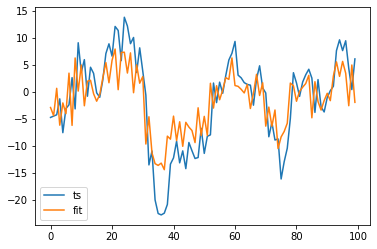

In [54]:
ts = np.cumsum(np.random.normal(0,5,100))
fit = ols_mets(ts,25)
fitted = ts - mets_filter(ts, fit[1], fit[0])
pd.DataFrame({'ts':ts,'fit':fitted}).plot()
print(fit)
print(np.exp(fit[1])-1)

In [56]:
def generate_mets(sample_size,alpha,rho):
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1
    
    L_approx[sample_size -1 ] = np.ones(sample_size)/sample_size

    wold_operator = np.linalg.inv(expm(-rho*L_approx))
    
    ep = np.random.normal(0,1,sample_size)
    return np.dot(wold_operator,ep)

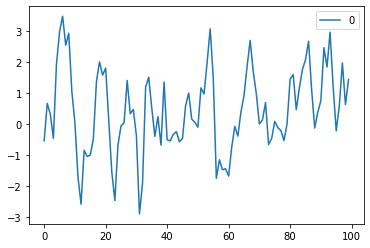

In [62]:
pd.DataFrame(generate_mets(100,0,.75)).plot()

# Simulations when DGP is AR(1) stationary

In [95]:
ar_rho = .75
sample_size = 20
sim_count = 1000

alpha_est = []
rho_est = []

for sim in range(0,sim_count):
    y_ar = np.array([0])
    for time in range(1,sample_size):
        y_ar = np.append(y_ar, ar_rho*y_ar[-1] + np.random.normal(0,1))
        
    mets_coefs = ols_mets(y_ar,30)
    alpha_est.append(mets_coefs[0])
    rho_est.append(mets_coefs[1])

Text(0.5, 1.0, 'Estimates for alpha')

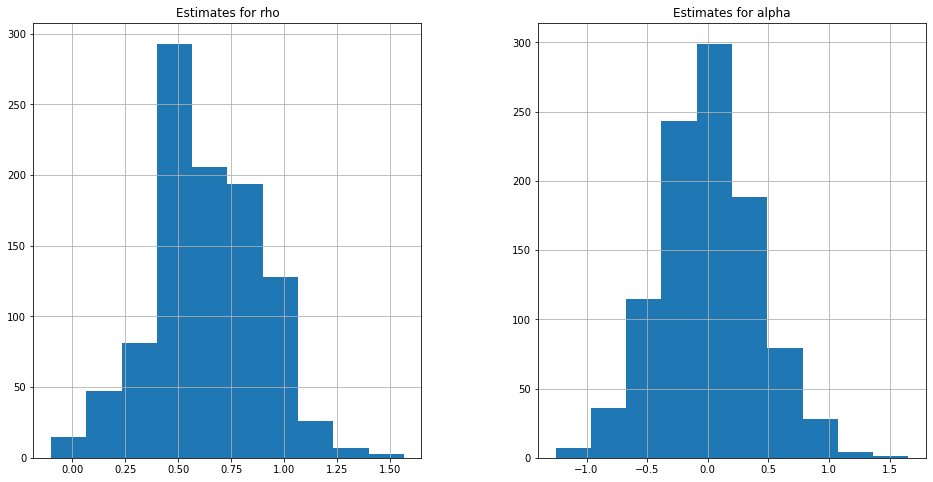

In [99]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (16,8))

pd.DataFrame(rho_est).multiply(-1.0).hist(ax=ax1)
ax1.set_title('Estimates for rho')

pd.DataFrame(alpha_est).hist(ax=ax2)
ax2.set_title('Estimates for alpha')

# Simulations when GDP is unit root

Text(0.5, 1.0, 'Estimates for alpha')

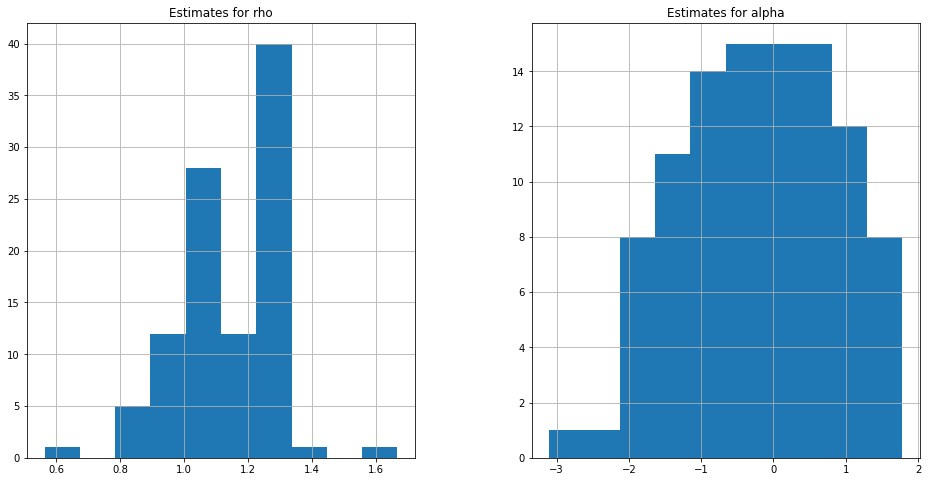

In [18]:
rw_rho = 1.0
sample_size = 50
sim_count = 100

rw_alpha_est = []
rw_rho_est = []

for sim in range(0,sim_count):
    y_rw = np.array([0])
    for time in range(1,sample_size):
        y_rw = np.append(y_rw, rw_rho*y_rw[-1] + np.random.normal(0,1))
        
    mets_coefs = ols_mets(y_rw,20)
    rw_alpha_est.append(mets_coefs[0])
    rw_rho_est.append(mets_coefs[1])
    
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (16,8))

pd.DataFrame(rw_rho_est).multiply(-1.0).hist(ax=ax1)
ax1.set_title('Estimates for rho')

pd.DataFrame(rw_alpha_est).hist(ax=ax2)
ax2.set_title('Estimates for alpha')

# Simulations when DGP is METS

In [117]:
mets_rho = .75
sample_size = 20
sim_count = 1000

alpha_est = []
rho_est = []

for sim in range(0,sim_count):
    y_mets = generate_mets(sample_size,0.0,mets_rho)
        
    mets_coefs = ols_mets(y_mets,30)
    alpha_est.append(mets_coefs[0])
    rho_est.append(mets_coefs[1])

Text(0.5, 1.0, 'Estimates for alpha')

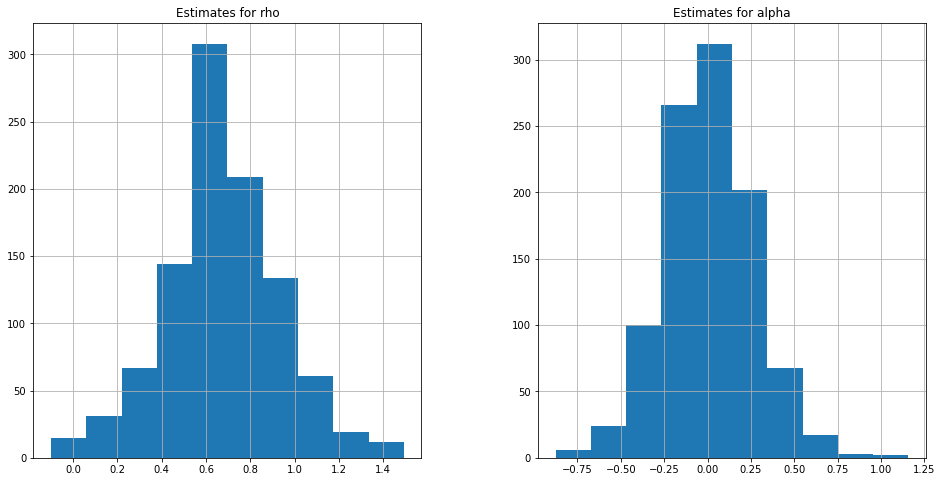

In [118]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (16,8))

pd.DataFrame(rho_est).multiply(-1.0).hist(ax=ax1)
ax1.set_title('Estimates for rho')

pd.DataFrame(alpha_est).hist(ax=ax2)
ax2.set_title('Estimates for alpha')

# Slow trend

In [129]:
ts = np.cos(np.linspace(0,3,25))+np.random.normal(0,1.1,25)

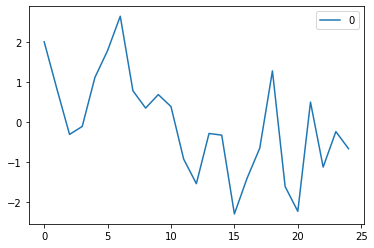

In [130]:
pd.DataFrame(ts).plot()

In [131]:
arma_model = ARIMA(ts, order=(1, 0, 0)).fit()
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -38.601
Date:                Fri, 16 Oct 2020   AIC                             83.203
Time:                        09:03:08   BIC                             86.859
Sample:                             0   HQIC                            84.217
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0077      0.387     -0.020      0.984      -0.766       0.751
ar.L1          0.4537      0.192      2.363      0.018       0.077       0.830
sigma2         1.2725      0.448      2.840      0.0

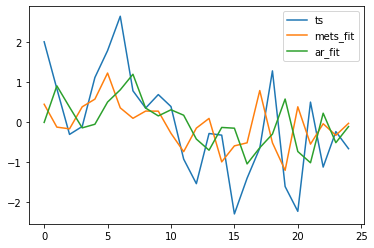

In [132]:
mets_fit = ols_mets(ts,25)
mets_fitted = ts - mets_filter(ts, mets_fit[1], mets_fit[0])
fitted_df = pd.DataFrame({'ts':ts,'mets_fit':mets_fitted, 'ar_fit':arma_model.predict()})
fitted_df.plot()

In [133]:
print( np.square(fitted_df['ts'] - fitted_df['ar_fit']).sum())
print( np.square(fitted_df['ts'] - fitted_df['mets_fit']).sum())

32.64606799698762
31.645025177556118


In [184]:
std_list = np.linspace(.25,.5,5)
ar_sse = np.zeros(len(std_list))
mets_sse = np.zeros(len(std_list))

sim_count = 10
for _ in range(0,sim_count):
    errors = np.random.normal(0,1,25)
    rw = np.cumsum(np.random.normal(0,1,25))
    index = 0
    for std in std_list:
        ts = 2*np.cos(np.linspace(0,6,25))+ rw+ std*errors
        arma_model = ARIMA(ts, order=(1, 0, 0)).fit()
        ar_sse[index] = ar_sse[index] + np.sum(np.square(ts- arma_model.predict()))

        mets_fit = ols_mets(ts,20)
        mets_fitted = ts - mets_filter(ts, mets_fit[1], mets_fit[0])
        mets_sse[index] = mets_sse[index] +np.sum(np.square(ts- mets_fitted))
        index = index +1

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [185]:
ar_sse/sim_count

array([37.70890246, 39.38734458, 41.4458569 , 43.87704694, 46.67187309])

In [186]:
mets_sse/sim_count

array([62.68748464, 65.09094515, 67.97827603, 71.32824581, 74.97018094])